One of the standard assumptions in regression models is that the error term is identically and independently distributed. One common violation of this assumption occurs when there is heteroskedasticity, which means that the error term has a variance that follows a pattern.

Typically, the amount of variability in the error term either increases or decreases with one or more variables, though more complex functions are possible too. For example, the variability of a return on a stock portfolio might depend on the number of stocks in that portfolio.

The possibility of heteroskedasticity should be considered in most contexts. It can be tested for using a variety of tests. If heteroskedasticity does exist, its presence does not bias results, but it does make estimates less efficient (i.e. accurate) and it invalidates standard inferences (i.e. hypothesis testing and confidence interval calculation). The latter issue can be addressed by using a simple correction called the HCCME; the former requires a more sophisticated fix called **Generalized Least Squares (GLS)** if the form of heteroskedasticity is known or Feasible Generalized Least Squares if it is not. Neither form of GLS are in scope for this course.

This cheat sheet will focus on the testing for heteroskedasticity and correcting the problem of inferences in the presence of heteroskedasticity. 

# Tasks

## Import the data into Python and train the model

The data can be found in the $\text{MMA 860 Assessing and Testing Data File v1.0}$ spreadsheet on its own worksheet.

In [1]:
import os.path as osp
import pandas as pd
from sklearn.linear_model import LinearRegression
import os

In [5]:
path = osp.join(
    osp.curdir,'Data',"MMA 860 Assessing and Testing Data File v1.0.xlsx")
data_path = osp.join(
    osp.curdir,'Data','Cheat_Sheet_Chow_Test_V1_0.xlsx')
import os
db_dir = os.getcwd()
data_path = db_dir+r"/MMA 860 Assessing and Testing Data File v1.0.xlsx"
data = pd.read_excel(data_path,sheet_name='Heteroskedasticity',index_col = 'Obs')
data.head()

,Y,X1,X2
Obs,,,
1,4084,38,22
2,4828,45,24
3,10304,98,21
4,5379,53,18
5,1670,14,27


In [6]:
X_train = data[['X1','X2']].values
y_train = data[['Y']].values

In [7]:
reg = LinearRegression().fit(X_train,y_train)

# Revisiting the Scale Location Plot

Examine the plot of the error term. You should see a fairly obvious example of heteroskedasticity similar to that shown in the chart below.

In [8]:
residuals = y_train - reg.predict(X_train)

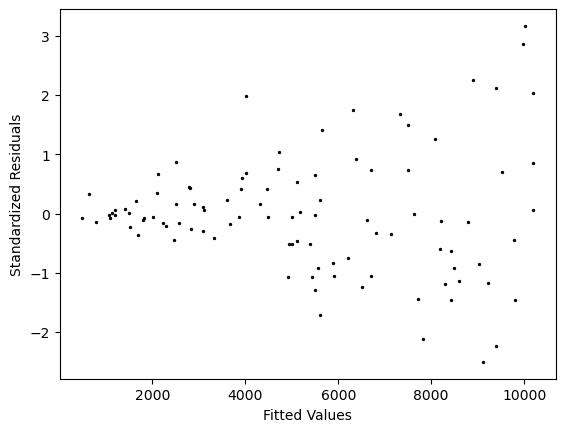

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import numpy as np

# First we create an array of normalized residuals using a Scikit function
scaler = StandardScaler().fit(residuals.reshape(-1,1))
norm_residuals = scaler.transform(residuals.reshape(-1,1))

# Plot and take the root and absolute values of the norms
plt.scatter(reg.predict(X_train),norm_residuals,c='black',s=2)
plt.xlabel("Fitted Values")
plt.ylabel("Standardized Residuals")
plt.show()

You can see here that as the predicted value of Y increases, the variance of the residual also increases. By producing a ‘residuals by regressor’ plot by you can gain more insight into where the heteroskedasticity originates.

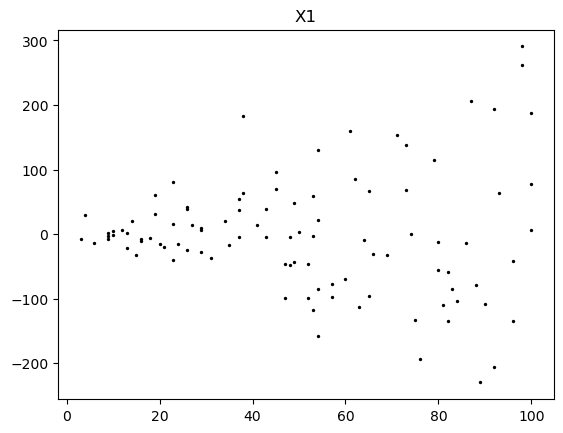

In [10]:
'''
To turn the X_train into the proper shape, we use the transpose function
on the array and index the correct vector of information.
'''
plt.scatter(X_train.transpose()[0],residuals,c='black',s=2)
plt.title("X1")
plt.show()

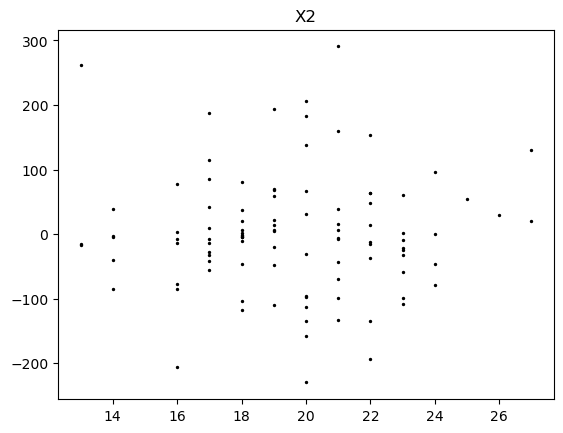

In [9]:
plt.scatter(X_train.transpose()[1],residuals,c='black',s=2)
plt.title("X2")
plt.show()

## The Breusch-Pagan Test 

There are several tests for heteroskedasticity, notably one by **Breusch-Pagan**. The Breusch-Pagan test is specifically for heteroskedasticity, however there exist other specification tests (notably, **White**) that test for broader specification errors. You can run the Breusch-Pagan test using the StatsModel library

The results of the Breusch-Pagan test will be a tuple of 4 values. The ones we are concerned about are the p-values. If either are less than $0.05$ then the model is found to be heteroskedastic.

In [12]:
#Import the relevant libraries and train the model
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import het_breuschpagan
results = ols('Y ~ X1 + X2',data).fit()

#Perform the Breuch-Pagan Test by running this line
bp = het_breuschpagan(results.resid,results.model.exog)
measures = ('LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value')
print(dict(zip(measures,bp)))

{'LM Statistic': 29.093195357985014, 'LM-Test p-value': 4.813853813579806e-07, 'F-Statistic': 19.899641254263912, 'F-Test p-value': 5.7327613417343636e-08}


•	LM Statistic: This is the Lagrange multiplier statistic for the test. A higher value typically indicates stronger evidence against the null hypothesis, which states that variance of the errors is constant (homoscedasticity).
•	LM-Test p-value: This is the p-value for the LM statistic. A p-value less than 0.05 typically leads to rejecting the null hypothesis, suggesting that the model is heteroskedastic.
•	F-Statistic: This statistic provides another way to test the hypothesis, using an F-distribution.
•	F-Test p-value: This is the p-value for the F-statistic, also used to determine the presence of heteroskedasticity.


•	The LM-Test p-value and the F-Test p-value are both extremely small (close to zero), which strongly suggests that the null hypothesis of homoscedasticity (constant variance of errors) should be rejected. Thus, the model is likely heteroskedastic.

## The HCCME (Heteroskedasticity Consistent Covariance Matrix Estimator) Method

If specification problems are detected, you can correct the inferences in the regression by using the HCCME method. This corrects the covariance matrix in the background to fix our hypothesis tests. There is a statsmodels function that allows us to do this.

In [13]:
'''
Below, we apply the mentioned function. It takes one argument, the HCCME
version. Typically HC3 is preferred, but HC2 can be used if your data 
has greater than 250 observations.
'''
corrected_model = results.get_robustcov_results(cov_type = 'HC3')
corrected_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 3.153e+04
Date:                Wed, 10 Jul 2024   Prob (F-statistic):          3.45e-137
Time:                        19:50:38   Log-Likelihood:                -593.82
No. Observations:                 100   AIC:                             1194.
Df Residuals:                      97   BIC:                             1201.
Df Model:                           2                                         
Covariance Type:                  HC3                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     93.1518     57.164      1.630      0.106     -20.302     206.606
X1            99.9793      0.411    243.550      0.000      99.165     100.794
X2             5.8192      3.078      1.890      0.062      -0.290      11.928
==============================================================================
Omnibus:                        7.895   Durbin-Watson:                   1.835
Prob(Omnibus):                  0.019   Jarque-Bera (JB):                8.486
Skew:                           0.481   Prob(JB):                       0.0144
Kurtosis:                       4.054   Cond. No.                         406.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

This produces heteroskedasticity-consistent inferences and tests in the same way a regular regression does. It will also use the corrected covariance matrix for any test statements used on the model.